----------------------------------------------------------
------------------------ Processes -----------------------
----------------------------------------------------------

Load datasets and split data for training and testing
Preprocess data
Merge Resale and Tampines datasets
Prepare Train/Test splits

----------------------------------------------------------
--------------- Resale Flat Prices Dataset ---------------
----------------------------------------------------------



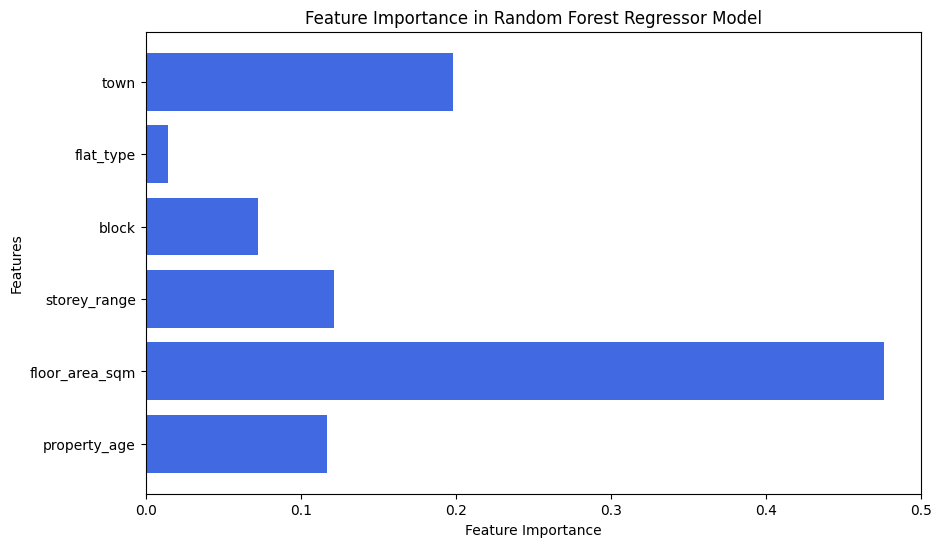

Feature Importances: [0.19852113 0.01425099 0.07258155 0.12172802 0.47622011 0.11669819]

R²: 0.5185
RMSE: 124856.59

----------------------------------------------------------
-------------------- Tampines Dataset --------------------
----------------------------------------------------------



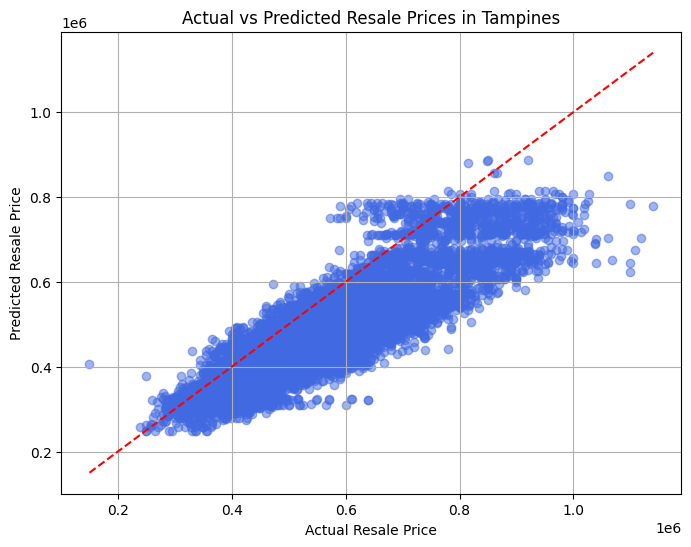


R²: 0.4303
RMSE: 115565.57
Prediction Accuracy: 84.70%

----------------------------------------------------------
--------------------- Merged Dataset ---------------------
----------------------------------------------------------



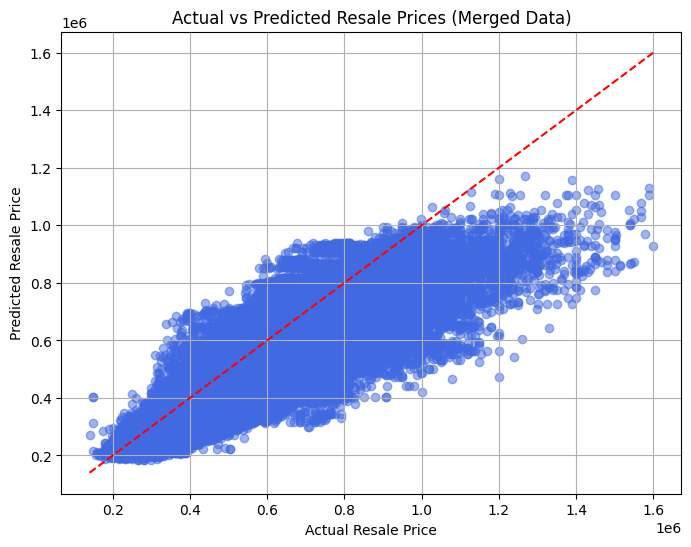


R²: 0.5162
RMSE: 124118.46
Prediction Accuracy: 82.80%


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


# ========================== SECTION 1 ========================== #
# ===================== Load & Process Data ===================== #

print("----------------------------------------------------------")
print("------------------------ Processes -----------------------")
print("----------------------------------------------------------\n")

# Load datasets
resale_df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
tampines_df = pd.read_csv("TampinesResaleFlat_with_LatLong_with_Features.csv")

# Convert 'month' to datetime and split data
resale_df['month'] = pd.to_datetime(resale_df['month'])
tampines_df['month'] = pd.to_datetime(tampines_df['month'])

# Split into training (2017-2020) and testing (2020-2023)
train_resale = resale_df[resale_df['month'] < '2020-01-01']
test_resale = resale_df[resale_df['month'] >= '2020-01-01']

train_tampines = tampines_df[tampines_df['month'] < '2020-01-01']
test_tampines = tampines_df[tampines_df['month'] >= '2020-01-01']

print("Load datasets and split data for training and testing")


# ========================== SECTION 2 ========================== #
# ======================= Data Processing ======================= #

# Preprocessing function
def preprocess_data(df):
    df = df.copy()  # Ensure we don't modify original data
    df['year'] = df['month'].dt.year
    df['month_num'] = df['month'].dt.month
    df.drop(columns=['month'], inplace=True)

    if 'remaining_lease' in df.columns:
        df['remaining_lease_years'] = df['remaining_lease'].str.extract('(\d+)').astype(float)
        df.drop(columns=['remaining_lease'], inplace=True)

    if 'lease_commence_date' in df.columns:
        df['property_age'] = 2023 - df['lease_commence_date']
        df.drop(columns=['lease_commence_date'], inplace=True)

    categorical_cols = ['town', 'flat_type', 'storey_range', 'flat_model', 'block', 'street_name']
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df

# Process datasets
train_resale = preprocess_data(train_resale)
test_resale = preprocess_data(test_resale)

train_tampines = preprocess_data(train_tampines)
test_tampines = preprocess_data(test_tampines)
print("Preprocess data")

# Merge Resale and Tampines datasets
def merge_datasets(df1, df2):
    merged_df = pd.concat([df1, df2], ignore_index=True)
    return merged_df

# Merge both datasets
train_merged_data = merge_datasets(train_resale, train_tampines)
test_merged_data = merge_datasets(test_resale, test_tampines)
print("Merge Resale and Tampines datasets")


# ========================== SECTION 3 ========================== #
# =================== Train & Evaluate Model ==================== #
# Function to calculate accuracy of predicted resale prices
def calculate_accuracy(y_actual, y_predicted):
    y_actual, y_predicted = np.array(y_actual), np.array(y_predicted)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100

    # Convert MAPE to Accuracy
    accuracy = 100 - mape
    return accuracy

# ===== 3.1: Resale Flat Prices Dataset ===== #
# Train model with different feature sets
def train_and_evaluate(feature_set, X_train, y_train, X_test, y_test):
    """
    Train Model using Resale Flat Prices Dataset and identify Feature Importance
    """
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)

    model.fit(X_train[feature_set], y_train)

    y_pred = model.predict(X_test[feature_set])
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Ensure squared=False

    return r2, rmse

# Selecting feature subsets
def tune_features(X_train, y_train, X_test, y_test, dataset_name):
    """
    Identify the best feature subset by testing different combinations of features, starting from a single feature
    and increasing up to the total number of features (11 features). Iterate each feature combination, train the
    model, evaluate its performance using R² and RMSE, and determine the best-performing feature subset that
    provides the highest predictive accuracy for the model.
    """
    feature_list = list(X_train.columns)
    best_r2 = -np.inf
    best_rmse = np.inf
    best_features = None

    print(f"\nTuning 1-feature combinations for {dataset_name} dataset:")

    # Only iterate for combinations of exactly 1 feature
    for subset in combinations(feature_list, 1):
        r2, rmse = train_and_evaluate(list(subset), X_train, y_train, X_test, y_test)
        print(f"Features: {subset} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")

        if r2 > best_r2:
            best_r2 = r2
            best_rmse = rmse
            best_features = subset

    print(f"\nBest 1-feature combination: {best_features}")
    print(f"Best R²: {best_r2:.4f}, Best RMSE: {best_rmse:.2f}")

    return best_features, best_r2, best_rmse

# Prepare train/test splits
X_train_resale = train_resale.drop(columns=['resale_price'])
y_train_resale = train_resale['resale_price']
X_test_resale = test_resale.drop(columns=['resale_price'])
y_test_resale = test_resale['resale_price']

X_train_tampines = train_tampines.drop(columns=['resale_price'])
y_train_tampines = train_tampines['resale_price']
X_test_tampines = test_tampines.drop(columns=['resale_price'])
y_test_tampines = test_tampines['resale_price']
print("Prepare Train/Test splits\n")

# Tuning of Resale Flat Prices data
# tune_features(X_train_resale, y_train_resale, X_test_resale, y_test_resale, "Resale Flat Prices")

# Plot Feature Importance after identifying feature subset
print("----------------------------------------------------------")
print("--------------- Resale Flat Prices Dataset ---------------")
print("----------------------------------------------------------\n")

def train_and_plot_feature_importance(train_data, test_data, selected_features, target_column='resale_price'):
    # Prepare training and testing data
    X_train = train_data[selected_features]
    y_train = train_data[target_column]
    X_test = test_data[selected_features]
    y_test = test_data[target_column]

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Get feature importances
    feature_importances = model.feature_importances_

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(selected_features, feature_importances, color='royalblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance in Random Forest Regressor Model")
    plt.gca().invert_yaxis()  # Invert for better readability
    plt.show()

    return feature_importances, r2, rmse

selected_features = ['town', 'flat_type', 'block', 'storey_range', 'floor_area_sqm', 'property_age']
feature_importances, r2, rmse = train_and_plot_feature_importance(train_resale, test_resale, selected_features)

print("Feature Importances:", feature_importances)

print(f"\nR²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# ===== 3.2: Tampines Dataset ===== #
# Train and evaluate the model using the selected features and plot Actual vs Predicted Prices
print("\n----------------------------------------------------------")
print("-------------------- Tampines Dataset --------------------")
print("----------------------------------------------------------\n")

def train_and_evaluate_tampines(train_data, test_data, selected_features, target_column='resale_price'):
    # Prepare training and testing data
    X_train = train_data[selected_features]
    y_train = train_data[target_column]
    X_test = test_data[selected_features]
    y_test = test_data[target_column]

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = calculate_accuracy(y_test, y_pred)

    # Plot Actual vs Predicted Prices
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect predictions line
    plt.xlabel("Actual Resale Price")
    plt.ylabel("Predicted Resale Price")
    plt.title("Actual vs Predicted Resale Prices in Tampines")
    plt.grid(True)
    plt.show()

    return r2, rmse, accuracy

# Define the selected features for training
selected_features = ['town', 'flat_type', 'block', 'storey_range', 'floor_area_sqm', 'property_age']

# Train and plot results
r2, rmse, accuracy = train_and_evaluate_tampines(train_tampines, test_tampines, selected_features)

print(f"\nR²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# ===== 3.3: Merged Dataset ===== #
# Train and evaluate the model using the selected features and plot Actual vs Predicted Prices
print("\n----------------------------------------------------------")
print("--------------------- Merged Dataset ---------------------")
print("----------------------------------------------------------\n")

def train_and_evaluate_merged(train_data, test_data, selected_features, target_column='resale_price'):
    # Prepare train-test splits
    X_train = train_data[selected_features]
    y_train = train_data[target_column]
    X_test = test_data[selected_features]
    y_test = test_data[target_column]

    # Train the model
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = calculate_accuracy(y_test, y_pred)

    # Plot Actual vs Predicted Prices
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect predictions line
    plt.xlabel("Actual Resale Price")
    plt.ylabel("Predicted Resale Price")
    plt.title("Actual vs Predicted Resale Prices (Merged Data)")
    plt.grid(True)
    plt.show()

    return r2, rmse, accuracy

# Train and evaluate on the merged dataset
r2, rmse, accuracy = train_and_evaluate_merged(train_merged_data, test_merged_data, selected_features)

print(f"\nR²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"Prediction Accuracy: {accuracy:.2f}%")